927/927 - 21s - loss: 9.5350e-04 - 21s/epoch - 23ms/step
8/8 [==============================] - 1s 10ms/step


<ipython-input-18-f0966ba53b40>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['prediction']=closing_price


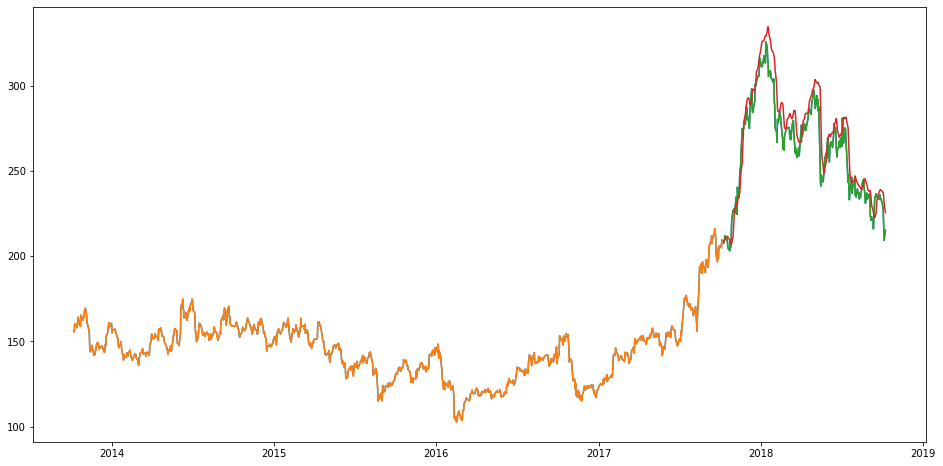

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM, Dropout,Dense

from sklearn.preprocessing import MinMaxScaler

df=pd.read_csv('NSE-Tata.csv')
df.head()

df["Date"]=pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df['Close'],label='close price history')

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=["Date",'Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset['Close'][i]=data["Close"][i]

new_dataset.index=new_dataset.Date
new_dataset.drop('Date',axis=1,inplace=True)

final_dataset=new_dataset.values

#splitting the data into train & test

train_dataset=final_dataset[0:987,:]
valid_dataset=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

#preparing train data
x_train,y_train=[],[]

for i in range(60,len(train_dataset)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
    
#model Building

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train,y_train,epochs=1,batch_size=1,verbose=2)

inputs_data=new_dataset[len(new_dataset)-len(valid_dataset)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

x_test=[]
for i in range(60,inputs_data.shape[0]):
    x_test.append(inputs_data[i-60:i,0])
x_test=np.array(x_test)

x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
closing_price=lstm_model.predict(x_test)
closing_price=scaler.inverse_transform(closing_price)

lstm_model.save("lstm_model.h5")

train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['prediction']=closing_price
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close','prediction']])